In [1]:
'''started on 10/20/2025'''

'started on 10/20/2025'

In [1]:
'''last updated on 12/11/2025
constraint from separate emulators within the training dataset'''

'last updated on 12/11/2025\nconstraint from separate emulators within the training dataset'

In [3]:
'''Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'''

'Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'

# import

In [4]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [5]:
import tol_colors as tc
from matplotlib.colors import LinearSegmentedColormap
from seaborn import palplot
import pyplot_themes as themes

In [6]:
from my_binned import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
from TOAf import *
from cyclone_obs import *
from cyclone_metrics import *

In [7]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

In [8]:
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

# data load

In [9]:
var_list = ['dPE_maps_gol', 'dTSmap_gol', 'wvp_maps_ol', 'w500_maps_ol', 'dLWPmap_gol', 'pe_maps_ol']
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
common_members = var_dict[var_keys[0]]["runs"].values
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

dPE_maps_gol
dTSmap_gol
wvp_maps_ol
w500_maps_ol
dLWPmap_gol
pe_maps_ol


In [10]:
dGMT = lat_weight_mean(var_dict['dTSmap_gol'])[0]

In [11]:
dLWP_g = var_dict['dLWPmap_gol']/dGMT  #[kgm-2K-1]
dLWP_g = dLWP_g.sel(runs=common_members)

In [12]:
dPE_p = var_dict['dPE_maps_gol']*86400/dGMT  #[kgm-2day-1K-1]
dPE_p = dPE_p.sel(runs=common_members)

In [13]:
wvp_g = var_dict['wvp_maps_ol']  #[kgm-2]
wvp_g = wvp_g.sel(runs=common_members)

In [14]:
w500_g = var_dict['w500_maps_ol']  #[Pas-1]
w500_g = w500_g.sel(runs=common_members)

In [15]:
pe_maps_ol = var_dict['pe_maps_ol']*86400  #[kgm-2day-1]
pe_maps_ol = pe_maps_ol.sel(runs=common_members)

In [16]:
file = np.load('/glade/derecho/scratch/cisong/backup_FOR_wyom0124/variables_filtered/pe.npz')
PE_g_mean = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  
PE_g_mean = PE_g_mean.sel(runs=common_members)  # [s-1]

In [17]:
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)

In [18]:
### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [19]:
## cyclone observations
from cyclone_obs import *
obs_dict = cyclone_obs()

# functions

## load_cf

In [20]:
def load_cf(FBcomp='SWcld_tot', common_members=common_members, dGMT=dGMT):
    # cloud feedback
    files = sorted(glob.glob(
        "/glade/derecho/scratch/travisa/CAM6_kernels/member_number_*/CAM6_PPE_CRK_decomp_all_pressure_all_cloud.nc"
    ))
    
    def drop_object_vars_and_coords(ds):
        obj_vars = [v for v in ds.data_vars if ds[v].dtype == object]  # Drop object dtype data variables
        obj_coords = [c for c in ds.coords if ds[c].dtype == object]  # Drop object dtype coordinates too
        to_drop = obj_vars + obj_coords
        if to_drop:
            ds = ds.drop_vars(to_drop)
        return ds
    
    cf = xr.open_mfdataset(
        files,
        combine="nested",
        concat_dim="runs",
        preprocess=drop_object_vars_and_coords,
        chunks={},             # disable auto rechunking
        parallel=False         # avoid Dask auto-guessing memory
    )
    
    cf = cf.assign_coords(runs=range(len(files)))
    cf_mean = cf.mean(dim="time", skipna=True)
    
    # Shift longitude from [0, 360) to [-180, 180)
    cf_mean = cf_mean.assign_coords(
        lon=(((cf_mean.lon + 180) % 360) - 180)
    )  
    cf_mean = cf_mean.sortby("lon")
    cf_mean = cf_mean.transpose("runs", "lat", "lon")  # reorder dimensions explicitly: runs, lat, lon
    print(cf_mean[FBcomp])
    
    totdCRE_g = cf_mean[FBcomp]/dGMT  #[Wm-2K-1] 
    common_members = np.intersect1d(common_members, totdCRE_g["runs"].values)
    totdCRE_g = totdCRE_g.sel(runs=common_members)
    return totdCRE_g

In [21]:
# totdCRE_g = load_cf('LWcld_amt')

In [22]:
# totdCRE_g[0].plot()

In [23]:
# # Select the first run (index 0)
# first_run = totdCRE_g.isel(runs=0)

# # Take mean across lat and lon
# mean_first_run = first_run.mean(dim=["lat", "lon"])
# mean_value = float(mean_first_run.values)
# print(mean_value)

## plot_pdfs_diff

In [24]:
def plot_pdfs_diff(data, bin_c, ninetyfive=None):
    if ninetyfive:
        conf = 2.5
        a = data
        a_min = np.percentile(a,conf)
        a_med = np.percentile(a,50)
        a_max = np.percentile(a,100.-conf)
        # print('the original range is: ',a_min,a_max)
        print('95th percentile taken')
        a = np.array(a)
        a_95 = a[(a >= a_min) & (a <= a_max)]
    else:
        a_95 = data

    hist, bins = np.histogram(a_95, bins=bin_c, density=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5

    return bin_centers, hist*np.diff(bins)

## SWD_da_func

In [25]:
# def SWD_da_func(convert, totdCRE_g, dLWP_g=dLWP_g, pe_maps_ol=pe_maps_ol, ocean=False):
#     Lv = 2264705.  # J/kg
    
#     ### ∆LWP map
#     dLWP_TSmap = dLWP_g.copy()  #datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
#     dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
#     dLWP_TSmap = dLWP_TSmap.sortby('lon')
    
#     ### cloud feedback
#     cf = totdCRE_g.copy()
#     cf = cf*convert   # multiply by convert value to consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
#     cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
#     cf = cf.sortby('lon')
    
#     ### PD MC map
#     PDMC_QFLX_da = pe_maps_ol.copy()
    
#     ### converging area
#     convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
#     # convergence_mask = PDMC_QFLX_da
    
#     ### incoming solar flux  #downwelling SW flux at TOA
#     SW_d_list = []
#     run_numbers = []
#     for fnum in range(263):
#         try:
#             fnums = f"{fnum:03d}"
#             SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
#             SW_maps = np.mean(SWfn_list['data'], axis=0)
#             # SW_mean = lat_weight_mean(SW_maps)
#             SW_d_list.append(SW_maps)
#             run_numbers.append(fnum)
#         except FileNotFoundError:
#             print(f'{fnums} not available.')
#             continue
#     SW_d_list = np.array(SW_d_list)
#     SWD_da = xr.DataArray(data=SW_d_list,
#                           coords={'runs': run_numbers,
#                                   'lat': SWfn_list['lat'],
#                                   'lon': SWfn_list['lon']},
#                           dims=['runs','lat','lon'])
#     SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
#     SWD_da = SWD_da.sortby('lon')  # [Wm-2]
#     if ocean:
#         from get_land_mask import get_land_mask
#         land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
#         land_mask_da = xr.DataArray(
#             land_mask,
#             coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
#             dims=['lat', 'lon']
#         )
#         SWD_da = SWD_da * land_mask_da

#     return convergence_mask, SWD_da



In [26]:
def SWD_da_func(convert, pe_maps_ol=pe_maps_ol, ocean=False):
    ### PD MC map
    PDMC_QFLX_da = pe_maps_ol.copy()
    
    ### converging area
    convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
    # convergence_mask = PDMC_QFLX_da
    
    ### incoming solar flux  #downwelling SW flux at TOA
    SW_d_list = []
    run_numbers = []
    for fnum in range(263):
        try:
            fnums = f"{fnum:03d}"
            SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
            SW_maps = np.mean(SWfn_list['data'], axis=0)
            # SW_mean = lat_weight_mean(SW_maps)
            SW_d_list.append(SW_maps)
            run_numbers.append(fnum)
        except FileNotFoundError:
            print(f'{fnums} not available.')
            continue
    SW_d_list = np.array(SW_d_list)
    SWD_da = xr.DataArray(data=SW_d_list,
                          coords={'runs': run_numbers,
                                  'lat': SWfn_list['lat'],
                                  'lon': SWfn_list['lon']},
                          dims=['runs','lat','lon'])
    SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
    SWD_da = SWD_da.sortby('lon')  # [Wm-2]
    if ocean:
        from get_land_mask import get_land_mask
        land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
        land_mask_da = xr.DataArray(
            land_mask,
            coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
            dims=['lat', 'lon']
        )
        SWD_da = SWD_da * land_mask_da

    return convergence_mask, SWD_da



## Load obs

In [27]:
# convert = 0.84  # multiply by 0.84 to consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)

In [28]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
# num_bins = 10
# ind = ~np.isnan(wcb * cloudlwp)

# # Calculate bins and statistics in one go
# bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
# lwp_bin, wcb_bin = bin_stats.statistic
# count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

# obs_grad_LWP_WCB = obs_grad.copy()

# lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
# upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

In [29]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']*24  #[mm/day]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

print(obs_grad)

obs_grad_LWP_PRC = obs_grad

uncertainty = np.sqrt(0.10**2 + 0.35**2)
lower_bound_PRC = obs_grad_LWP_PRC - uncertainty * obs_grad_LWP_PRC  # updated to include the sampling uncertainty
upper_bound_PRC = obs_grad_LWP_PRC + uncertainty * obs_grad_LWP_PRC

0.008106015839806293


In [30]:
pe_metric = PPE_grad_LWP_PRC #PPE_grad_LWP_WCB
obs_pe_metric = obs_grad_LWP_PRC #obs_grad_LWP_WCB
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  #lower_bound_WCB, upper_bound_WCB
xtitle = '$∂LWP/∂P_{EC}$' #'$∂LWP/∂WCB_{EC}$'

In [31]:
#### MERRA2 constraint by area of convergence * SWD
Lv = 2264705.  # J/kg
ocean=False
## Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merra_conv_area*merraSW

In [32]:
# default, default_sem, _ = lat_weight_mean(sel_regime(cf,0,90))

In [33]:
# def plot_pdfs(data, bin_c):
#     conf = 2.5
#     a = data
#     a_min = np.percentile(a,conf)
#     a_med = np.percentile(a,50)
#     a_max = np.percentile(a,100.-conf)
#     # print('the original range is: ',a_min,a_max)
#     print('95th percentile taken')
#     a = np.array(a)
#     a_95 = a[(a >= a_min) & (a <= a_max)]

#     hist, bins = np.histogram(a_95, bins=bin_c, density=True)
#     bin_centers = (bins[1:]+bins[:-1])*0.5

#     return bin_centers, hist

## sel_regime

In [34]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')
    print(xarray_sel.shape)

    return xarray_sel


## emulate_regimes

In [35]:
# #### old
# # GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.mixture import GaussianMixture  
# import numpy as np

# def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p):
#     # Determine valid (non-NaN) points
#     ind = ~np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p)
    
#     # Stack predictors
#     input = np.column_stack((
#         x_p.data[ind], 
#         y_p1.data[ind],
#         y_p2.data[ind]*y_p3.data[ind]
#     ))
#     output = c_p[ind]

#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(
#         input, output, test_size=0.2, random_state=42
#     )

#     # Define parameter grid
#     param_grid = {
#         'n_estimators': [100, 200],
#         'max_depth': [3, 5, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 3, 5],
#         'bootstrap': [True, False]
#     }

#     # Initialize RF Regressor
#     rf = RandomForestRegressor(random_state=13)

#     # GridSearchCV setup
#     grid_search = GridSearchCV(
#         estimator=rf,
#         param_grid=param_grid,
#         cv=3,                  # 3-fold cross-validation
#         scoring='r2',          # R² score
#         verbose=2,
#         n_jobs=-1              # Use all processors
#     )

#     # Fit GridSearchCV
#     grid_search.fit(X_train, y_train)

#     # Best model
#     best_rf = grid_search.best_estimator_
#     # print("Best Hyperparameters:", grid_search.best_params_)

#     # Predict on training set with best RF
#     Ptrain = best_rf.predict(X_train)

#     # Metrics
#     r2 = r2_score(y_train, Ptrain)
#     mse = mean_squared_error(y_train, Ptrain)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_train, Ptrain)
    
#     print("Training Performance with Best RF:")
#     print("R² Score:", r2)  
#     print("MSE:", mse)
#     print("RMSE:", rmse)
#     print("MAE:", mae)

#     # GMM sampling
#     n_samples = 1_000_000
#     gmm = GaussianMixture(n_components=3, random_state=0)
#     gmm.fit(X_train)

#     X_new, _ = gmm.sample(n_samples)
#     P_new = best_rf.predict(X_new)

#     return X_new, P_new

In [36]:
# === Random Forest Emulator with Density Masking ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture  
import numpy as np

def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p, density_percentile=5, n_samples=1_000_000):
    """
    Train a Random Forest emulator and predict only within high-density regions 
    of the training data, based on a Gaussian Mixture Model (GMM).

    Parameters
    ----------
    x_p, y_p1, y_p2, y_p3, c_p : np.ndarray
        Predictor and target arrays (same shape).
    density_percentile : float, optional
        Percentile cutoff for low-density masking (default=5 -> keep top 95% densest samples).
    n_samples : int, optional
        Number of GMM-sampled points to evaluate with the emulator.

    Returns
    -------
    X_dense : np.ndarray
        Predictor samples within high-density regions.
    P_dense : np.ndarray
        Emulator predictions corresponding to X_dense.
    best_rf : sklearn.ensemble.RandomForestRegressor
        Trained Random Forest model.
    """

    # --- Step 1: Determine valid (non-NaN) points ---
    ind = ~np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p)
    
    # --- Step 2: Stack predictors and target ---
    X = np.column_stack((
        x_p.data[ind], 
        y_p1.data[ind],
        y_p2.data[ind] * y_p3.data[ind]
    ))
    y = c_p[ind]

    # --- Step 3: Train-test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Step 4: Define parameter grid for Random Forest ---
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=13)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # --- Step 5: Training performance ---
    Ptrain = best_rf.predict(X_train)
    r2 = r2_score(y_train, Ptrain)
    mse = mean_squared_error(y_train, Ptrain)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, Ptrain)

    print("\n=== Training Performance with Best RF ===")
    print(f"R²:   {r2:.3f}")
    print(f"MSE:  {mse:.3e}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")

    # --- Step 6: Fit GMM to training data ---
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(X_train)

    # --- Step 7: Sample new points and compute their density ---
    X_new, _ = gmm.sample(n_samples)
    log_density = gmm.score_samples(X_new)

    # --- Step 8: Keep only high-density regions ---
    density_threshold = np.percentile(log_density, density_percentile)
    high_density_mask = log_density > density_threshold

    X_dense = X_new[high_density_mask]
    P_dense = best_rf.predict(X_dense)

    print(f"\nKept {high_density_mask.sum():,} / {len(X_new):,} samples "
          f"({100 * high_density_mask.sum()/len(X_new):.1f}%) "
          f"within top {100 - density_percentile:.0f}% density region.")

    # --- Optional: Evaluate on test data ---
    Ptest = best_rf.predict(X_test)
    r2_test = r2_score(y_test, Ptest)
    print(f"Test R²: {r2_test:.3f}")

    return X_dense, P_dense


## RFresults

In [37]:
#### uncomment the lines noted to get the RF run
#### comment to show the plots only  
dLWP_TSmap = dLWP_g.copy()
def RFresults(min_lat, max_lat, FBcomp, cf, convergence_mask, SWD_da, dLWP_TSmap=dLWP_TSmap, pe_metric=pe_metric, filtered_TOA_15=filtered_TOA_15):
    print(FBcomp)
    print('lats: ', min_lat, max_lat)
    # lat_ranges = [(0,20, 'tropics'), (20, 50, 'subtropics'), (50, 90, 'extratropics')]
    
    # PPE_prior = []
    # RF_prior = []
    # RF_posterior = []
    # constrain_arr = []
    # MC_constrained = []
    
    # for idx, min_lat, max_lat:
    dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(cf,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']
    # plt.figure(); plt.scatter(x_p.values, y_p.values, c=c_p.values, cmap='jet')
    # plt.colorbar(label=FBcomp)
    # plt.xlabel('∂LWP/∂P'); plt.ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$')
    X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p.values)

    pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
    conv_constrained = (X_new[:,2] >= obs_constraint_lower) & (X_new[:,2] <= obs_constraint_upper)
    both_constrained = pe_constrained & conv_constrained
    # P_new_constrained = P_new[both_constrained]

    # PPE_prior.append([x_p.data, y_p.data, c_p.data])
    # RF_prior.append([X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], P_new])
    # RF_posterior.append(P_new_constrained)
    # constrain_arr.append(constrained)
    # MC_constrained.append(conv_constrained)

    return X_new[:,0], X_new[:,1]*X_new[:,2], P_new, both_constrained, conv_constrained

####### to save the npz files if needed
    # np.savez(fig_dir+FBcomp+'_kernel_RF_results.npz', 
    #          PPE_prior=PPE_prior, RF_prior=RF_prior, RF_posterior=RF_posterior, runs=x_p.runs, constrain_arr=constrain_arr, MC_constrained=MC_constrained)
    # print(fig_dir+FBcomp+'_kernel_RF_results.npz')


# emulate for CF components

In [38]:
files = "/glade/derecho/scratch/travisa/CAM6_kernels/member_number_000/CAM6_PPE_CRK_decomp_all_pressure_all_cloud.nc"
allData = xr.open_dataset(files)

In [39]:
var_names = list(allData.data_vars.keys())
print(var_names)


['LWcld_tot', 'LWcld_ctp', 'LWcld_tau', 'LWcld_res', 'SWcld_tot', 'SWcld_ctp', 'SWcld_tau', 'SWcld_res', 'LWcld_amt', 'SWcld_amt']


In [40]:
# weights (must sum to 1)
lat_bounds = [(0,20), (20, 50), (50, 90)]
weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
weights = np.array(weights) / np.sum(weights)
w_sub, w_ext, w_trop = weights[1], weights[2], weights[0]

##  SWcld_tau

In [41]:
### total cloud feedback
FBcomp = 'SWcld_tau'
totdCRE_g = load_cf('SWcld_tau')
convert = 1  #0.84  # multiplying factor to be consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
convergence_mask, SWD_da = SWD_da_func(convert=convert)
default, default_sem, _ = lat_weight_mean(sel_regime(totdCRE_g,0,90))
# total from the subtropics
min_lat, max_lat = 20, 50
sub_RF_precipeff_cyc, sub_RF_dLWP, sub_RF_CF, sub_constrained_indices, sub_conv_constrained = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)
# total from the tropics
min_lat, max_lat = 0, 20
tr_RF_precipeff_cyc, tr_RF_dLWP, tr_RF_CF, tr_constrained_indices, tr_conv_constrained = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)
# total from the extratropics
min_lat, max_lat = 50, 90
ext_RF_precipeff_cyc, ext_RF_dLWP, ext_RF_CF, ext_constrained_indices, ext_conv_constrained = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)



<xarray.DataArray 'SWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
(252, 192, 288)
SWcld_tau
lats:  20 50
(253, 64, 288)
(253, 64, 288)
(263, 64, 288)
(252, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.38209017983144

=== Training Performance with Best RF ===
R²:   0.404
MSE:  3.118e-02
RMSE: 0.177
MAE:  0.133

Kept 950,000 / 1,000,000 samples (95.0%) within top 95% density region.
Test R²: -0.041
SWcld_tau
lats:  0 20
(253, 42, 288)
(253, 42, 288)
(263, 42, 288)
(252, 42, 288)
(81, 576)
1082.0025788794226 992.9501967281166 1171.0549610307285

=== Training Performance with Best RF ===
R²:   0.347
MSE:  7.275e-02
RMSE: 0

## previous

In [39]:
### total cloud feedback
FBcomp = 'LW+SW_tot'
totdCRE_g = load_cf('SWcld_tot')+load_cf('LWcld_tot')
default, default_sem, _ = lat_weight_mean(sel_regime(totdCRE_g,0,90))
# total from the subtropics
min_lat, max_lat = 20, 50
_, _, sub_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)
# total from the tropics
min_lat, max_lat = 0, 20
_, _, tr_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)
# total from the extratropics
min_lat, max_lat = 50, 90
_, _, ext_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totdCRE_g, convergence_mask, SWD_da)



<xarray.DataArray 'SWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'LWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
(252, 192, 288)
LW+SW_tot
lats:  20 50
(253, 64, 288)
(253, 64, 288)
(263, 64, 288)
(252, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.3

In [40]:
global_prior = w_sub*sub_RF_CF_tot + w_ext*ext_RF_CF_tot + w_trop*tr_RF_CF_tot  # global prior sample

In [41]:
def prior_post(sub_RF_CF, sub_constrained_indices=None):
    if sub_constrained_indices is not None:
        print('if')
        sub_RF_CF_post = sub_RF_CF[sub_constrained_indices]  # Posterior data (constrained subset)  
        low, high = np.nanpercentile(sub_RF_CF_post, [5, 95])  # 5th–95th percentile range of posterior
    else:
        print('else')
        low, high = np.nanpercentile(sub_RF_CF, [5, 95])
    post_samples = np.random.uniform(low, high, 1000)  # Draw 1000 samples uniformly within this range
    return post_samples

In [30]:
### working on this cell to get everything to pne function
FBcomp = 'SWcld_tau'
totdCRE_g = load_cf('SWcld_tau') 
convert = 1  #0.84  # multiplying factor to be consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
convergence_mask, SWD_da = SWD_da_func(convert=convert)
cf = totdCRE_g.copy()
# emulator from the subtropics
min_lat, max_lat = 20, 50
sub_RF_precipeff_cyc, sub_RF_dLWP, sub_RF_CF, sub_constrained_indices, sub_conv_constrained = RFresults(min_lat, max_lat, FBcomp, cf, convergence_mask, SWD_da)
plt.figure()
plt.hexbin(sub_RF_precipeff_cyc, sub_RF_dLWP, gridsize=50, C=sub_RF_CF, cmap='jet')
plt.title(FBcomp)
plt.colorbar()

<xarray.DataArray 'SWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261


In [59]:

sub_post_samples = prior_post(sub_RF_CF, sub_constrained_indices) + prior_post(sub_RF_CF_tot-sub_RF_CF)  # 1000 posterior values for subtropics
ext_post_samples = prior_post(ext_RF_CF, ext_constrained_indices) + prior_post(ext_RF_CF_tot-ext_RF_CF)  # 1000 posterior value for extratropics
tr_post_samples = prior_post(tr_RF_CF_tot)  # 1000 value from the prior for tropics
global_posterior = w_sub*sub_post_samples + w_ext*ext_post_samples + w_trop*tr_post_samples


if
else
if
else
else


In [32]:
'''getting the following to the above cell'''

'getting the following to the above cell'

In [65]:
FBcomp = 'SWcld_tau'
totdCRE_g = load_cf('SWcld_tau')  #+load_cf('SWcld_amt')+load_cf('LWcld_tau')+load_cf('LWcld_amt')  # SWcld_tot in default

<xarray.DataArray 'SWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261


In [66]:
convert = 1  #0.84  # multiplying factor to be consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
convergence_mask, SWD_da = SWD_da_func(convert=convert, totdCRE_g=totdCRE_g)

In [67]:
cf = totdCRE_g.copy()


In [69]:
# emulator from the subtropics
min_lat, max_lat = 20, 50
sub_RF_precipeff_cyc, sub_RF_dLWP, sub_RF_CF, sub_constrained_indices, sub_conv_constrained = RFresults(min_lat, max_lat, FBcomp, cf, convergence_mask, SWD_da)


SWcld_tau
lats:  20 50
(253, 64, 288)
(253, 64, 288)
(263, 64, 288)
(252, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.38209017983144

=== Training Performance with Best RF ===
R²:   0.404
MSE:  3.118e-02
RMSE: 0.177
MAE:  0.133

Kept 950,000 / 1,000,000 samples (95.0%) within top 95% density region.
Test R²: -0.041


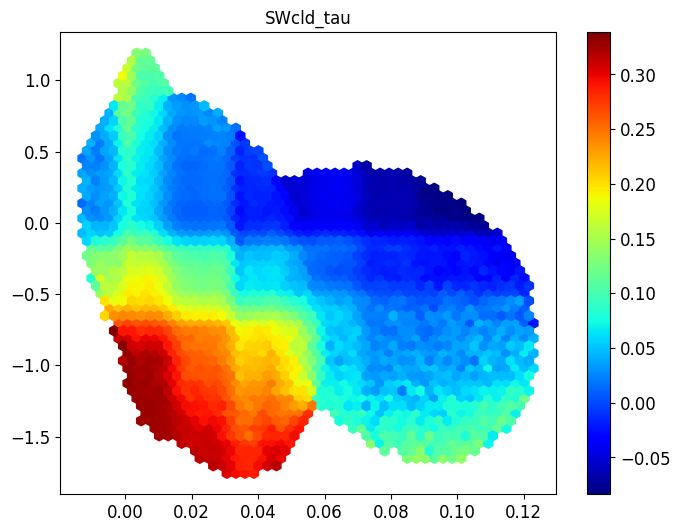

In [72]:
plt.figure()
plt.hexbin(sub_RF_precipeff_cyc, sub_RF_dLWP, gridsize=50, C=sub_RF_CF, cmap='jet')
plt.title(FBcomp)
plt.colorbar()

In [73]:
# constraint from the extratropics
min_lat, max_lat = 50, 90
ext_RF_precipeff_cyc, ext_RF_dLWP, ext_RF_CF, ext_constrained_indices, ext_conv_constrained = RFresults(min_lat, max_lat, FBcomp, cf, convergence_mask, SWD_da)


SWcld_tau
lats:  50 90
(253, 86, 288)
(253, 86, 288)
(263, 86, 288)
(252, 86, 288)
(162, 576)
256.8365084498096 238.8468865316165 274.82613036800274

=== Training Performance with Best RF ===
R²:   0.349
MSE:  5.920e-02
RMSE: 0.243
MAE:  0.189

Kept 950,000 / 1,000,000 samples (95.0%) within top 95% density region.
Test R²: 0.057


Text(0.5, 1.0, 'SWcld_tau')

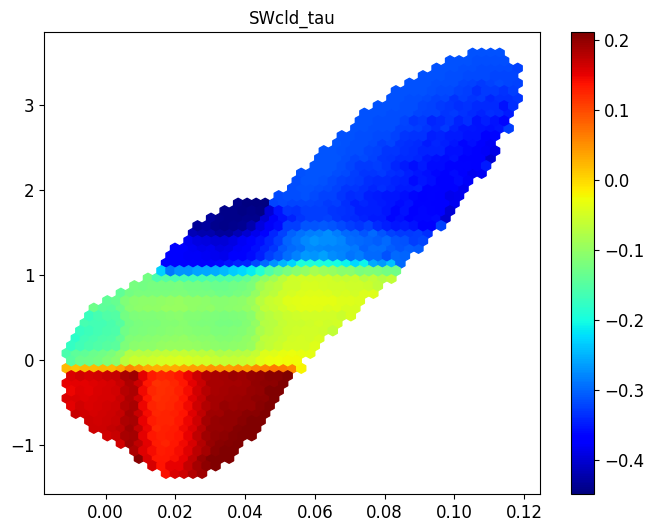

In [74]:
plt.figure()
plt.hexbin(ext_RF_precipeff_cyc, ext_RF_dLWP, gridsize=50, C=ext_RF_CF, cmap='jet')
plt.colorbar()
plt.title(FBcomp)

In [52]:
### total cloud feedback
FBcomp = 'LW+SW_tot'
totdCRE_g = load_cf('SWcld_tot')+load_cf('LWcld_tot')
default, default_sem, _ = lat_weight_mean(sel_regime(totdCRE_g,0,90))

<xarray.DataArray 'SWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'LWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
(252, 192, 288)


In [56]:
print(tr_RF_CF_tot.shape, sub_RF_CF_tot.shape, ext_RF_CF_tot.shape)

(950000,) (950000,) (950000,)


In [57]:
print(sub_constrained_indices.shape, ext_constrained_indices.shape)

(950000,) (950000,)


1.01574576309388 0.5487832109422368
0.9320824739629747 0.7021813485631417


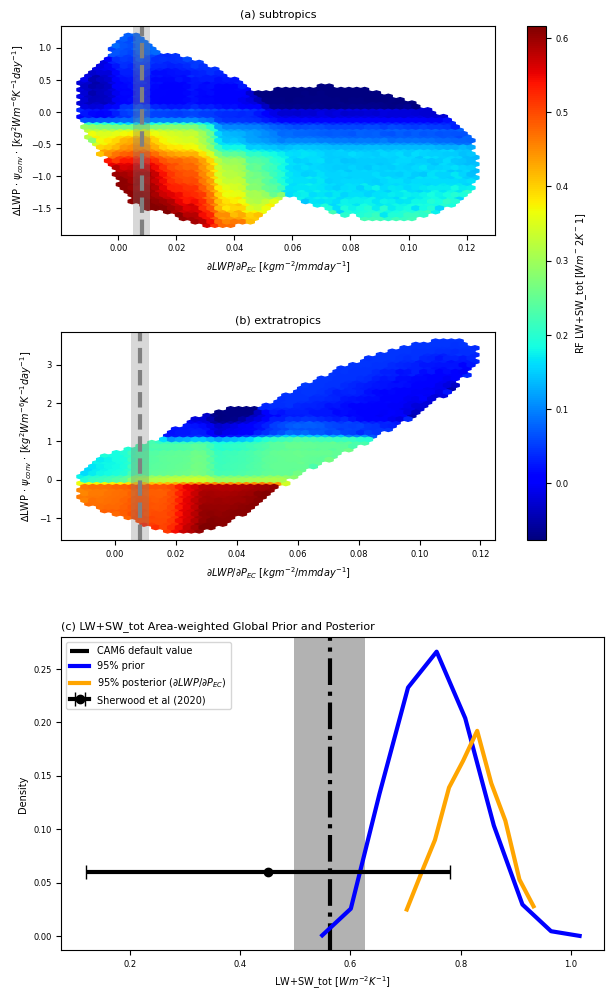

In [60]:
# lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
import matplotlib.gridspec as gridspec
regimes = ['subtropics', 'extratropics']
# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 3, width_ratios=[18, 0.8, 1.1], height_ratios=[2, 2, 3], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

RF_pe = {
    "subtropics": sub_RF_precipeff_cyc,
    "extratropics": ext_RF_precipeff_cyc
}  # precipitation efficiencies from the RF
RF_dLWP = {
    "subtropics": sub_RF_dLWP,
    "extratropics": ext_RF_dLWP
}  # ∆LWP from the RF
RF_cf = {
    "subtropics": sub_RF_CF,
    "extratropics": ext_RF_CF
}  # cloud feedback from the RF

MC_constrained = {
    "subtropics": sub_conv_constrained,
    "extratropics": ext_conv_constrained
}  # constrained Moisture convergence from RF

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    regime = regimes[ax_n]  # what is the regime
    pe = RF_pe[regime]  # get the precipitation efficiency in respective regime
    dLWP = RF_dLWP[regime]  # get the dLWP (y axis) in respective regime
    CF = RF_cf[regime]  # get the cf in respective regime
    
    img = ax.hexbin(pe, dLWP, C=CF, 
                     gridsize=50, cmap='jet')
    # p_temp = PPE_prior[ax_n+1]
    # x_p = xr.DataArray(p_temp[0], dims=['runs'], coords={'runs': runs})
    # y_p = xr.DataArray(p_temp[1], dims=['runs'], coords={'runs': runs})
    # c_p = xr.DataArray(p_temp[2], dims=['runs'], coords={'runs': runs})

    # p_img = ax.scatter(x_p, y_p, c=c_p, 
    #                     cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    # constrained = constrain_arr[ax_n+1]
    # conv_constrained = MC_constrained[regime]  # Moisture convergence constraints in regime
    # ax.scatter(temp[0][conv_constrained], temp[1][conv_constrained], 
    #            edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)

    # from scipy.stats import gaussian_kde
    # x = pe[conv_constrained]  # MC constrained precipitation efficiencies
    # y = dLWP[conv_constrained]  # MC constrained dLWP (y axis)
    # kde = gaussian_kde([x, y])
    # xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 50),
    #                      np.linspace(y.min(), y.max(), 50))
    # zi = kde([xi.ravel(), yi.ravel()]).reshape(xi.shape)
    # ax.contour(xi, yi, zi, levels=5, colors='grey', linewidths=1.2)  # contours for the constraints on MC reanalysis

    # constraint lines on precipitation efficiency observations
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    # plot features
    ax.set_xlabel(xtitle+' $[kgm^{-2}/mmday^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)


# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
# cbar.set_label('RF $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cbar.set_label(f'RF {FBcomp} $[Wm^-2K^-1]$', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# p_cbar_ax = fig.add_subplot(gs[0:2, 3])  # Span both top rows in the fourth column
# cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
# cbar.set_label('PPE $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Constrained PDF (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
ax_scatter.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
ax_scatter.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
print(np.max(pr_bin_centers), np.min(pr_bin_centers))

po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')



# # constrained range from the Sherwood et al 2020 for the SW component
# means = [0.25, 0.12, 0]
# stds = [0.16, 0.12, 0.1]
# mu_total, sigma_total = combine_independent(means, stds)
# print(f'Sherwood et al 2020 results: {mu_total}, {sigma_total}')
# ax_scatter.errorbar(mu_total, 0.06, xerr=1.96*sigma_total, fmt='o-', label='Sherwood et al (2020)', capsize=5, capthick=1, color='black')
# constrained range from the Sherwood et al 2020 for the total cloud feedback
ax_scatter.errorbar(0.45, 0.06, xerr=0.33, fmt='o-', label='Sherwood et al (2020)', capsize=5, capthick=1, color='black')

ax_scatter.legend(fontsize=label_fontsize)
print(np.max(po_bin_centers), np.min(po_bin_centers))

# ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
ax_scatter.set_xlabel(FBcomp+' $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
ax_scatter.set_ylabel('Density', fontsize=label_fontsize)
ax_scatter.set_title(title_num[2]+FBcomp+' Area-weighted Global Prior and Posterior', 
                     loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

# plt.savefig(fig_dir+FBcomp+'_totalglobal_constraint.png',
#             bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


In [61]:
default[0].compute()

<xarray.DataArray ()>
array(0.562168)
Coordinates:
    runs     int64 0

In [62]:
# Remove NaNs if any
pr_valid = pr_bin_centers[np.isfinite(pr_bin_centers)]
po_valid = po_bin_centers[np.isfinite(po_bin_centers)]

# Compute range (max - min)
prior_range = np.max(pr_valid) - np.min(pr_valid)
posterior_range = np.max(po_valid) - np.min(po_valid)

# Compute reduction percentage
reduction_percent = ((prior_range - posterior_range) / prior_range) * 100

print(f"Prior range: {prior_range:.3f}")
print(f"Posterior range: {posterior_range:.3f}")
print(f"Constrained reduction: {reduction_percent:.2f}%")


Prior range: 0.467
Posterior range: 0.230
Constrained reduction: 50.77%


In [63]:
po_valid = pr_bin_centers[np.isfinite(pr_bin_centers)]

posterior_mean = np.mean(po_valid)
posterior_std = np.std(po_valid)

print(f"Prior mean: {posterior_mean:.3f}")
print(f"Prior std: {posterior_std:.3f}")


Prior mean: 0.782
Prior std: 0.149


In [64]:
po_valid = po_bin_centers[np.isfinite(po_bin_centers)]

posterior_mean = np.mean(po_valid)
posterior_std = np.std(po_valid)

print(f"Posterior mean: {posterior_mean:.3f}")
print(f"Posterior std: {posterior_std:.3f}")


Posterior mean: 0.817
Posterior std: 0.073
